# Tailsitter prototype for aerial mapping - Calculations

This notebook contains the following important calculations regarding the prototype:
- Motor thrust, RPM, power, current and overall propulsion system efficiency estimations for takeoff and hover
- Image quality analysis
- Ground Sample Distance estimation

## Motor thrust data based on measurements by KremerFPV

In [10]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d



data = {
    'ESC_signal': ['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'],
    'Torque_Nm': [0.008, 0.029, 0.059, 0.095, 0.136, 0.182, 0.238, 0.306, 0.372, 0.416],
    'Thrust_gf': [44.048, 165.727, 346.696, 569.856, 827.020, 1119.430, 1464.596, 1866.815, 2266.404, 2539.159],
    'Voltage_V': [16.047, 16.041, 16.027, 16.005, 15.970, 15.924, 15.864, 15.785, 15.693, 15.600],
    'Current_A': [0.229, 0.923, 2.310, 4.634, 7.998, 12.556, 18.619, 26.811, 36.485, 45.865],
    'Motor_RPM': [1576, 2922, 4065, 5091, 6008, 6922, 7854, 8837, 9653, 10259],
    'Electrical_Power_W': [3.674, 14.811, 37.030, 74.173, 127.724, 199.939, 295.372, 423.197, 572.539, 715.501],
    'Mechanical_Power_W': [1.356, 8.896, 25.171, 50.849, 85.707, 132.261, 196.083, 283.574, 375.931, 446.871],
    'Motor_Efficiency': [36.949, 60.065, 67.990, 68.563, 67.112, 66.152, 66.390, 67.009, 65.663, 62.456],
    'Propeller_Mech_Efficiency': [32.949, 18.632, 13.774, 11.208, 9.650, 8.464, 7.469, 6.583, 6.029, 5.682],
    'Overall_Efficiency': [11.995, 11.190, 9.364, 7.684, 6.476, 5.599, 4.959, 4.411, 3.959, 3.549]
}

table = pd.DataFrame(data)
print(table)

  ESC_signal  Torque_Nm  Thrust_gf  Voltage_V  Current_A  Motor_RPM  \
0        10%      0.008     44.048     16.047      0.229       1576   
1        20%      0.029    165.727     16.041      0.923       2922   
2        30%      0.059    346.696     16.027      2.310       4065   
3        40%      0.095    569.856     16.005      4.634       5091   
4        50%      0.136    827.020     15.970      7.998       6008   
5        60%      0.182   1119.430     15.924     12.556       6922   
6        70%      0.238   1464.596     15.864     18.619       7854   
7        80%      0.306   1866.815     15.785     26.811       8837   
8        90%      0.372   2266.404     15.693     36.485       9653   
9       100%      0.416   2539.159     15.600     45.865      10259   

   Electrical_Power_W  Mechanical_Power_W  Motor_Efficiency  \
0               3.674               1.356            36.949   
1              14.811               8.896            60.065   
2              37.030        

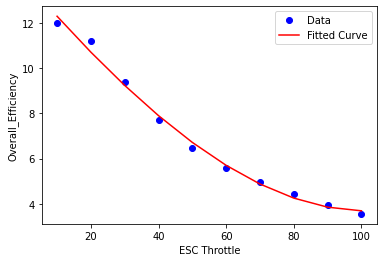

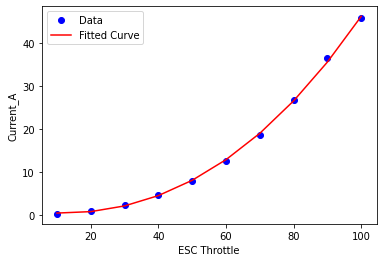

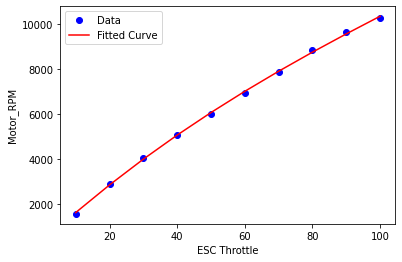

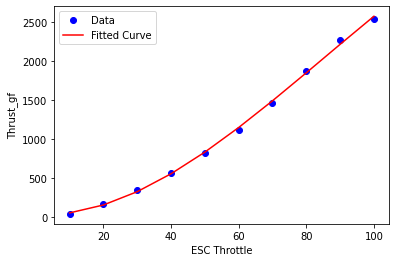

Coefficients:
{'Overall_Efficiency': array([ 2.88578147e-06,  4.16194532e-04, -1.73438747e-01,  1.39824333e+01]), 'Current_A': array([ 1.41954268e-05,  4.10790600e-03, -9.92615787e-02,  9.92832120e-01]), 'Motor_RPM': array([ 1.32303807e-03, -4.94702797e-01,  1.36428244e+02,  3.19533333e+02]), 'Thrust_gf': array([-1.76084713e-03,  4.51935117e-01, -2.22143533e+00,  3.58601000e+01])}


In [11]:
def polynomial(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

# Convert ESC throttle signals to numerical values
data['ESC_signal'] = [int(x[:-1]) for x in data['ESC_signal']]
x_data = np.array(data['ESC_signal'])

# Variables to be estimated
variables = ['Overall_Efficiency', 'Current_A', 'Motor_RPM', 'Thrust_gf']

# Initialize a dictionary to store coefficients
coefficients = {}

for variable in variables:
    y_data = np.array(data[variable])
    popt, _ = curve_fit(polynomial, x_data, y_data)
    coefficients[variable] = popt

print("Coefficients:")
print(coefficients)

In [14]:
# Find the ESC throttle for 650g and 1300g thrust
thrust_func = interp1d(polynomial(x_data, *coefficients['Thrust_gf']), x_data)
thrust_650_esc = thrust_func(650)
thrust_1300_esc = thrust_func(1300)


# Print the ESC throttle, current, and RPM for 650g and 1300g thrust
thrust_levels = {'650g': thrust_650_esc, '1300g': thrust_1300_esc}
for level, esc in thrust_levels.items():
    print(f"{level} Thrust:")
    print(f"  ESC Throttle: {esc:.2f}%")
    print(f"  Current: {polynomial(esc, *coefficients['Current_A']):.2f} A")
    print(f"  RPM: {polynomial(esc, *coefficients['Motor_RPM']):.2f}")
    print(f"  Overall efficiency: {polynomial(esc, *coefficients['Overall_Efficiency']):.2f}")

650g Thrust:
  ESC Throttle: 43.34%
  Current: 5.56 A
  RPM: 5410.95
  Overall efficiency: 7.48
1300g Thrust:
  ESC Throttle: 64.41%
  Current: 15.44 A
  RPM: 7408.39
  Overall efficiency: 5.31


In [16]:
x = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])  # Convert ESC signal to decimals
y = np.array(data['Thrust_gf'])                  

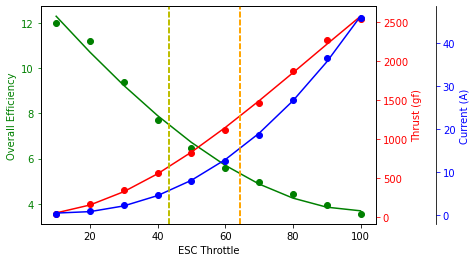

In [18]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax3 = ax1.twinx()

# Offset the right spine of ax3, to avoid overlapping
ax3.spines['right'].set_position(('outward', 60))

variables_axes = [('Overall_Efficiency', ax1, 'g'), ('Thrust_gf', ax2, 'r'), ('Current_A', ax3, 'b')]

for variable, axis, color in variables_axes:
    axis.plot(x_data, data[variable], f'{color}o', label=f'{variable} Data')
    axis.plot(x_data, polynomial(x_data, *coefficients[variable]), f'{color}-', label=f'{variable} Fitted')
    axis.axvline(thrust_650_esc, color='y', linestyle='--', label='650g Thrust')
    axis.axvline(thrust_1300_esc, color='orange', linestyle='--', label='1300g Thrust')
    axis.yaxis.label.set_color(color)
    axis.tick_params(axis='y', colors=color)

ax1.set_xlabel('ESC Throttle')
ax1.set_ylabel('Overall Efficiency')
ax2.set_ylabel('Thrust (gf)')
ax3.set_ylabel('Current (A)')

# Add the legend to the plot
# fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.85))

plt.show()

### Image quality assessment

Calculate Laplacian variance score to measure clarity and sharpness of the image. Extract all the frames from a video

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

# Define function to extract frames from a video
def extract_frames(video_path, num_frames):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    # Get the frame rate and total number of frames in the video
    fps = cap.get(cv2.CAP_PROP_FPS)
    print("Frames per second:", fps)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print("Total frame count:", frame_count)
    # Calculate the interval at which to extract frames
    interval = frame_count // num_frames
    # Create an empty list to store the extracted frames
    frames = []
    # Loop over the desired number of frames
    print("Extracting", num_frames, "frames")
    for i in range(num_frames):
        # Calculate the frame number to extract
        frame_num = i * interval
#         frame_num = i
        # Set the capture position to the desired frame
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
        # Read the frame
        ret, frame = cap.read()
        # Check if the frame was successfully read
        if not ret:
            break
        # Append the frame to the list
        frames.append(frame)
    # Release the video capture object
    cap.release()
    # Return the list of extracted frame
    return frames

# Define function to select frames with different qualities
def select_quality_frames(frames):
    # Create a list to store the Laplacian variance scores
    scores = []
    # Loop over the frames and calculate the Laplacian variance score for each
    for frame in frames:
        score = cv2.Laplacian(frame, cv2.CV_64F).var()
        scores.append(score)
    # Find the indices of the frames with the worst, median, and best scores
    worst_index = scores.index(min(scores))
    median_index = np.argsort(scores)[len(scores)//2]
    best_index = scores.index(max(scores))
    # Return the frames with the corresponding indices and their Laplacian variance scores
    return frames[worst_index], worst_index, scores[worst_index], frames[median_index], median_index, scores[median_index], frames[best_index], best_index, scores[best_index]




In [3]:
# Specify the path to the video file and the number of frames to extract
video_path = "RC_0017_2211211856.mp4"
num_frames = 120

# Extract the desired frames from the video
frames = extract_frames(video_path, num_frames)

Frames per second: 30.0
Total frame count: 9639
Extracting 120 frames


In [4]:
# Measure execution time
start_time = time.time()
# Select frames with different qualities
worst_frame, worst_index, worst_score, median_frame, median_index, median_score, best_frame, best_index, best_score = select_quality_frames(frames)
print(f"Execution time: {time.time() - start_time:.4f} seconds for", num_frames, "frames")

Execution time: 6.6180 seconds for 120 frames


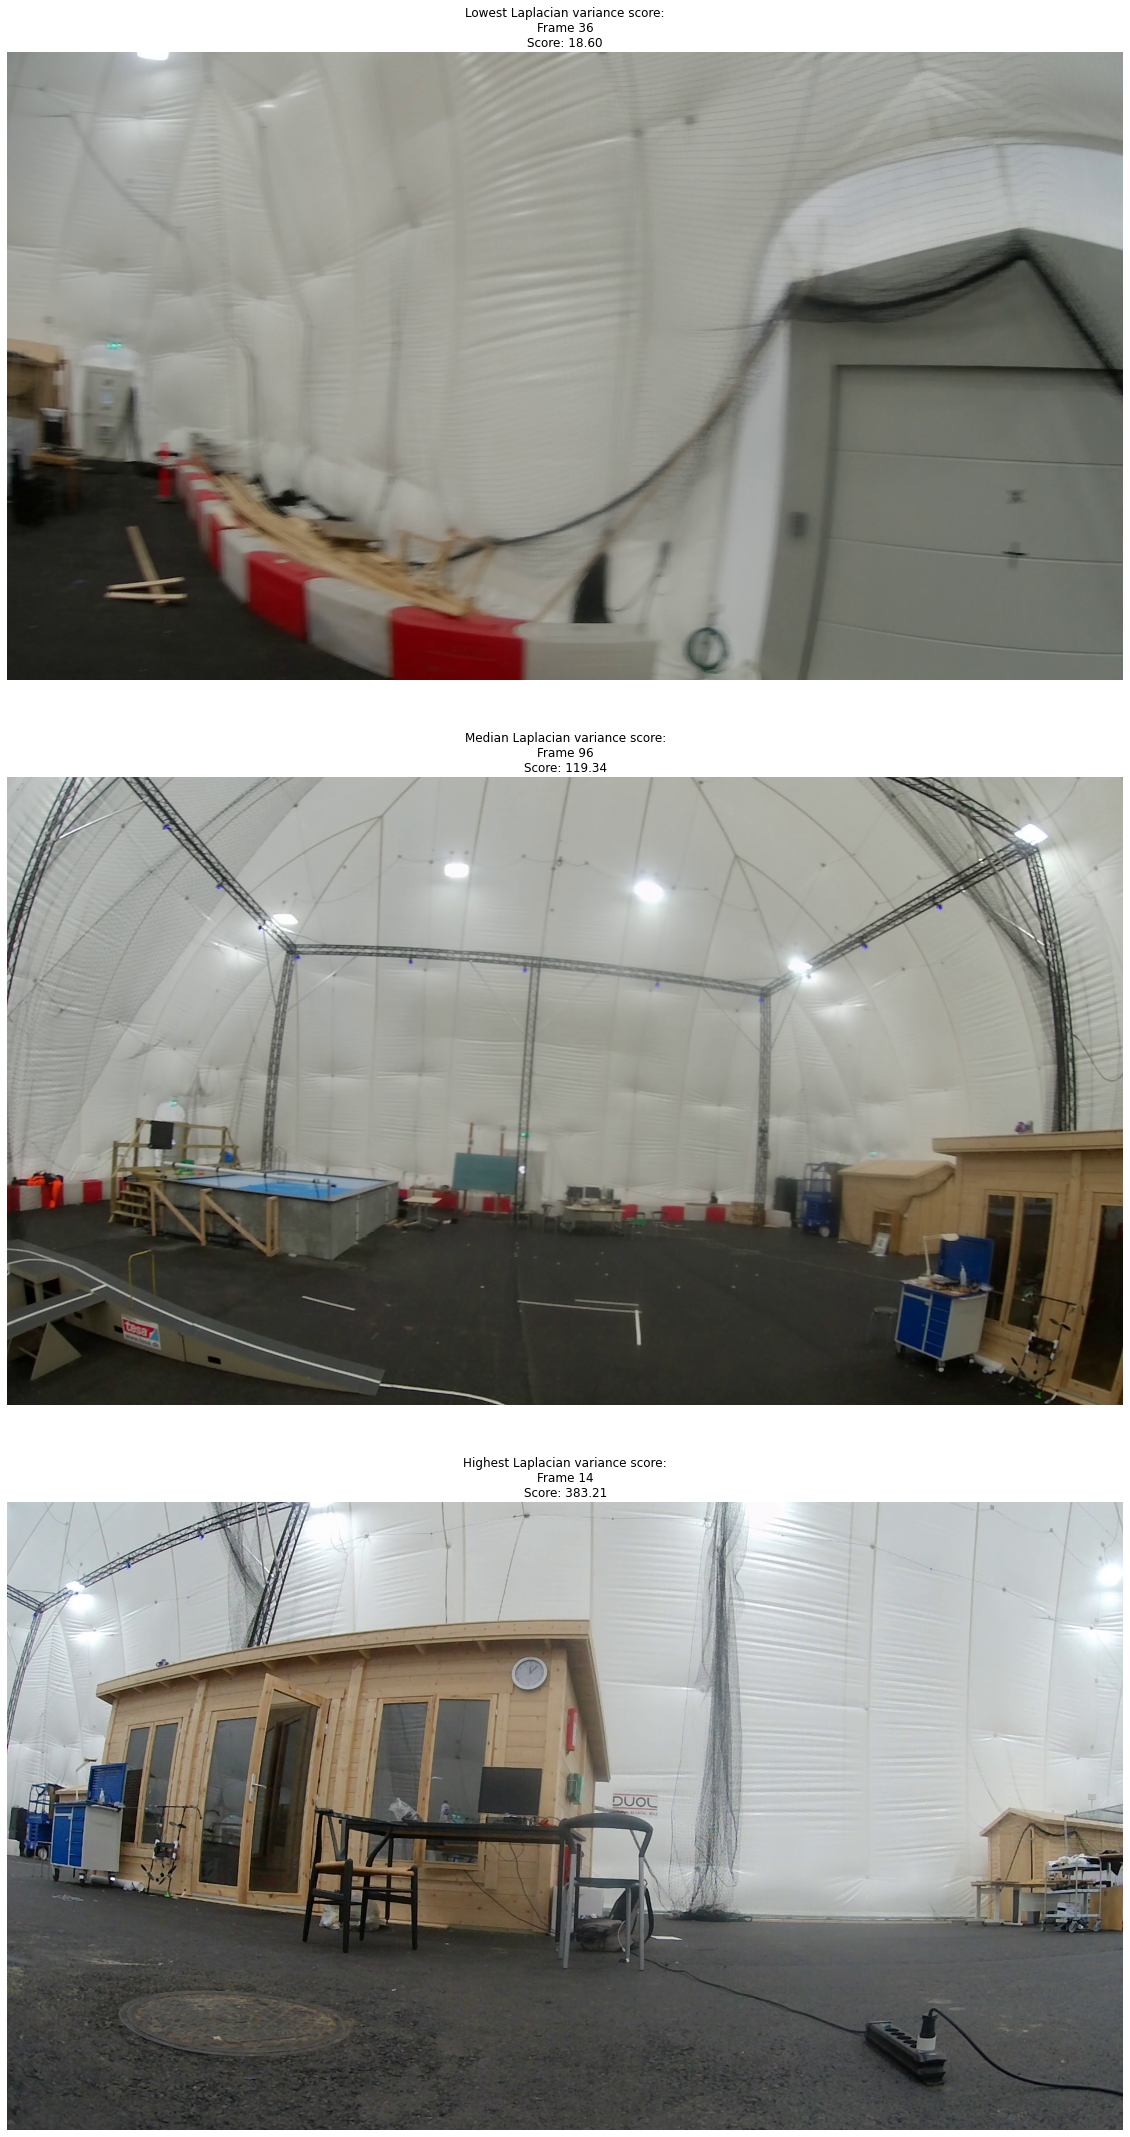

In [26]:
# Create a figure with 1 row and 3 columns
fig, axes = plt.subplots(3, 1, figsize=(20, 40))

# Plot the worst quality frame
axes[0].imshow(cv2.cvtColor(worst_frame, cv2.COLOR_BGR2RGB))
axes[0].set_title(f"Lowest Laplacian variance score:\nFrame {worst_index}\nScore: {worst_score:.2f}")
axes[0].axis("off")

# Plot the median quality frame
axes[1].imshow(cv2.cvtColor(median_frame, cv2.COLOR_BGR2RGB))
axes[1].set_title(f"Median Laplacian variance score:\nFrame {median_index}\nScore: {median_score:.2f}")
axes[1].axis("off")

# Plot the best quality frame
axes[2].imshow(cv2.cvtColor(best_frame, cv2.COLOR_BGR2RGB))
axes[2].set_title(f"Highest Laplacian variance score:\nFrame {best_index}\nScore: {best_score:.2f}")
axes[2].axis("off")
plt.subplots_adjust(wspace=0, hspace=0)

Further no reference image quality assessent methods provided by pyiqa library

In [36]:
from pyiqa
import cv2
print(pyiqa.list_models())

# Load the image
img_path = 'best_frame.jpg'
img = cv2.imread(img_path)

['ahiq', 'brisque', 'ckdn', 'cw_ssim', 'dbcnn', 'dists', 'fid', 'fsim', 'gmsd', 'ilniqe', 'lpips', 'lpips-vgg', 'mad', 'maniqa', 'ms_ssim', 'musiq', 'musiq-ava', 'musiq-koniq', 'musiq-paq2piq', 'musiq-spaq', 'nima', 'niqe', 'nlpd', 'nrqm', 'paq2piq', 'pi', 'pieapp', 'psnr', 'ssim', 'vif', 'vsi']


In [39]:
import pyiqa
import torch


# create Brisque metric with default setting
iqa_metric = pyiqa.create_metric('brisque')


# check if lower better or higher better
print(iqa_metric.lower_better)

print(iqa_metric(img_path))

Downloading: "https://github.com/chaofengc/IQA-PyTorch/releases/download/v0.1-weights/brisque_svm_weights.pth" to C:\Users\Tongifangi\.cache\torch\hub\checkpoints\brisque_svm_weights.pth




True
tensor([22.8537])


# Ground Sample Distance (GSD) calculation

In [73]:
import math

def calculate_vfov(fov, resolution_x, resolution_y):
    vfov = 2 * math.atan(math.tan(math.radians(fov) / 2) * (resolution_y / resolution_x))
    return math.degrees(vfov)

def calculate_gsd_x(altitude, vfov, resolution_y):
    gsd = (2 * altitude * math.tan(math.radians(vfov / 2))) / resolution_y
    return gsd

def calculate_gsd_y(altitude, hfov, resolution_x):
    gsd = (2 * altitude * math.tan(math.radians(hfov / 2))) / resolution_x
    return gsd


def calculate_max_shutter_speed(ground_speed, spatial_resolution):
    max_shutter_speed = spatial_resolution / ground_speed
    return max_shutter_speed

Let's suppose the UAV is flying at 100m altitude with 12.5m/s (45km/h) ground speed.

In [74]:
altitude = 100  # Altitude in meters
ground_speed = 12.5  # Ground speed in meters per second

### Oak-D Lite

In [75]:
# Based on Oak-D Lite specifications
hfov = 69  # Horizontal Field of View in degrees
vfov = 54  # Horizontal Field of View in degrees
resolution_x = 4208
resolution_y = 3120

Calculate GSD:

In [76]:
gsd_x = calculate_gsd_x(altitude, hfov, resolution_x)
gsd_y = calculate_gsd_y(altitude, vfov, resolution_y)
print(f"Ground Sample Distance x (GSD_x): {gsd_x:.5f} meters")
print(f"Ground Sample Distance y (GSD_y): {gsd_y:.5f} meters")

Ground Sample Distance x (GSD_x): 0.03267 meters
Ground Sample Distance y (GSD_y): 0.03266 meters


Maximum exposure time calculation:

In [77]:
max_shutter_speed = calculate_max_shutter_speed(ground_speed, gsd_y)
print(f"Maximum exposure time Speed: {max_shutter_speed:.5f} seconds")

Maximum exposure time Speed: 0.00261 seconds


### Raspberry Pi HQ wide angle

In [78]:
# Based on Raspberry Pi HQ wide angle specifications
hfov = 64  # Horizontal Field of View in degrees
vfov = 49.5  # Vertical Field of View in degrees
resolution_x = 4056
resolution_y = 3040

Calculate GSD:

In [79]:
gsd_x = calculate_gsd_x(altitude, hfov, resolution_x)
gsd_y = calculate_gsd_y(altitude, vfov, resolution_y)
print(f"Ground Sample Distance x (GSD_x): {gsd_x:.5f} meters")
print(f"Ground Sample Distance y (GSD_y): {gsd_y:.5f} meters")

Ground Sample Distance x (GSD_x): 0.03081 meters
Ground Sample Distance y (GSD_y): 0.03033 meters


Maximum exposure time speed calculation

In [80]:
max_shutter_speed = calculate_max_shutter_speed(ground_speed, gsd_y)
print(f"Maximum exposure time: {max_shutter_speed:.5f} seconds")

Maximum exposure time: 0.00243 seconds


### RunCam Hybrid 2

In [81]:
# Based on Raspberry Pi HQ wide angle specifications
hfov = 145  # Horizontal Field of View in degrees
vfov = 49.5  # Vertical Field of View in degrees
resolution_x = 3840
resolution_y = 2160

Estimate vertical field of view based on the resolution:

In [82]:
vfov = calculate_vfov(hfov, resolution_x, resolution_y)
print(f"Vertical Field of View (VFOV): {vfov:.2f} degrees")

Vertical Field of View (VFOV): 121.46 degrees


Calculate GSD:

In [83]:
gsd_x = calculate_gsd_x(altitude, hfov, resolution_x)
gsd_y = calculate_gsd_y(altitude, vfov, resolution_y)
print(f"Ground Sample Distance x (GSD_x): {gsd_x:.5f} meters")
print(f"Ground Sample Distance y (GSD_y): {gsd_y:.5f} meters")

Ground Sample Distance x (GSD_x): 0.16519 meters
Ground Sample Distance y (GSD_y): 0.16519 meters
